## 1. Forward Imaging Model
In this process, the sample is illuminated with one LED of the grid at time and a camera captures Lo-Res images under different incident angle. To simulate it, we have to:

1. Create a Hi-Res complex image.

2. Generate the incident wave vectors.

3. Produce the ouput images.

In [161]:
from PIL import Image
import numpy as np
from math import pi, floor
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [162]:
%matplotlib inline

In [163]:
# 1. Create the Hi-Res complex image.
amplitude = Image.open('../img/cameraman.tif')
phase = Image.open('../img/westconcordorthophoto.png')

In [164]:
phase = phase.resize((256, 256), resample=Image.BICUBIC)

In [165]:
arr_amplitude = np.array(amplitude, dtype='d')
arr_phase = np.array(phase, dtype='d')

In [166]:
arr_phase = pi * arr_phase / np.amax(arr_phase)

In [167]:
arr_obj = arr_amplitude * np.exp(pi * arr_phase)
arr_obj = np.absolute(arr_obj)  # The Hi-Res complex image.

In [168]:
# Using PIL, the objects is shown as an image almost completely white.
# img_obj = Image.fromarray(arr_obj)
# img_obj.show()

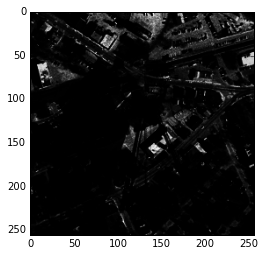

In [169]:
# Using matplotlib anc 'Greys_r' ('str') as value for cmap key [1],
# the object is shown like in Matlab R2009b.
#
# [1] unutbu. (2010). Display image as grayscale using matplotlib [Msg 1]. Message posted to
# http://stackoverflow.com/questions/3823752/display-image-as-grayscale-using-matplotlib?answertab=votes#tab-top
plt_img = plt.imshow(arr_obj, cmap='Greys_r')

In [170]:
# 2. Generate the incident wave vectors.
# Return a n-by-n array with magnitude of the x-component, kx, and y-component, ky, of
# the wave vectors of the incident waves that emerge from the LED grid.
def generate_wave_vectors(**kwargs):
    n = kwargs.pop('n', 15)  # Order of the n-by-n array.
    dist = kwargs.pop('dist', 4)  # Distance in mm between LEDs.
    h = kwargs.pop('h', 90)  # Distance in mm between the LED grid and the sample.
    x_max = floor((n / 2)) * dist
    x_min = -x_max
    y_max = x_max
    y_min = x_min
    l_row = list()
    l_arr = list()
    l_range = list(range(x_min, x_max + 1, dist))  # xy_max (int) + 1 to include xy_max.
    for i in l_range:
        for j in l_range:
            l_row.append((j, i))
        l_arr.append(l_row)
        l_row = list()
    arr = np.array(l_arr)  # arr ('numpy.ndarray') contains (x, y) coordinates.
    arr = arr / h
    arr = np.arctan(arr)
    arr = np.sin(arr)
    arr = -arr # arr contains [kx, ky] elements.
    return arr

## References
Zheng, G. (2015). Forward imaging model. In *Fourier Ptychographic Imaging: A MATLAB&reg; tutorial*. San Rafael, CA: Morgan &amp; Claypool Publishers.  